In [1]:
import numpy as np
import h5py
import os 
import json
import scipy.io as spio
import matplotlib.pyplot as plt 
import pickle


# This is a python implementation of 

# Jin et al. (2015), Adaptive reference updating for vibration-based
# structural health monitoring under varying environmental conditions,
# Computers & Structures.

In [2]:
##  SIMULATION OPTIONS 
# (1) Select Damage Scenario

# Four damage senarios are available as below:
# case0_lin: No damage occurs under linear dependency to temp.
# case1_lin: Damage occurs at #sample of 700  under linear dependency to temp
# case0_bi_lin: No damage occurs under non-linear dependency to temp.
# case1_bi_lin: Damage occurs at #sample of 700 under non-linear dependency to temp

## uncommnet senario that you want to run 

# fn='case0_lin'; # No damage // Quasi-Linear
# fn='case1_lin'; # Damage at #700 // Quasi-Linear
fn='case0_bi_lin'; # No damage // Bi-linear 
# fn= 'case1_bi_lin'; # Damage at #700 // Bi-linear 

In [3]:
## (2) Select Noise Level
# SNR 100dB: No noise
# SNR 60dB: Noise injected
# Smaller SNR indicates large noise
noise_amp=0.00001; # SNR 100 dB
# noise_amp=0.001; # SNR 60 dB

In [4]:
## (3) Define Size of Initial Training Sample
# Do not define the size above 700 for the damage scenarios (i.e., case1_*.mat)
n_init = 200;

In [5]:
## (4) Define file name for saving simulated data
fn_sv = 'DB_' + fn + '_' + str(noise_amp) + '.h5' # Change filename as you wish

In [6]:
simul_data = spio.loadmat(os.path.join('DB_for_Scenario', fn+'.mat'))

In [7]:
t = simul_data['t']
Elem_temp = simul_data['Elem_temp']
Elem_damage = simul_data['Elem_damage']
D_point = simul_data['D_point']
D_Quan = simul_data['D_Quan']
Phi_Z1 = simul_data['Phi_Z1']
Phi_R1 = simul_data['Phi_R1']
Freq = simul_data['Freq']

<function matplotlib.pyplot.show>

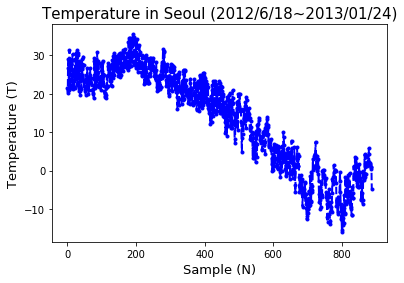

In [8]:
## Plot Hist. of Temp.
# Temperature history of Seoul was obtained from www.kma.go.kr
# Period for sampling: 2012/6/18~2013/01/24

%matplotlib inline
plt.plot(np.array(range(0, t.shape[1])), t[0], 'bo--', linewidth=2, markersize=3)
plt.title('Temperature in Seoul (2012/6/18~2013/01/24)', fontsize=15)
plt.xlabel('Sample (N)',fontsize=13)
plt.ylabel('Temperature (T)',fontsize=13)
plt.show

In [9]:
## Plot Temperature Dependency

if 'bi' in fn : # Bi-Linear
    T0, Es  = [-16, 0, 31 ], [1.3, 1, 0.98]
    p1 = np.polyfit(T0[0:2], Es[0:2], 1)
    p2 = np.polyfit(T0[1:3], Es[1:3], 1)

    factor = np.zeros(t.shape)

    B0_ = np.argwhere(t<0)
    B0, IX0 = np.transpose(B0_[:,0]), np.transpose(B0_[:,1])

    B1_ = np.argwhere((t>0) | (t==0))
    B1, IX1 = np.transpose(B1_[:,0]), np.transpose(B1_[:,1])

    Factor = np.zeros(t.shape[1])
    Factor[IX0] = p1[0]*t[0, IX0]+p1[1]
    Factor[IX1] = p2[0]*t[0, IX1]+p2[1]

    Factor1 = p1[0]*t[0, 0:33]+p2[1]
    Factor2 = p2[0]*t[0, 33:]+p2[1]

    title_Freq_VS_t_str = 'Bi-Linear'
    
else : # Quasi-Linear
    T0 = np.arange(-20, 51, 5)
    Es = np.array([1.07523676300626,1.06253244739916,1.05077090900101,1.03995214781181,
                  1.03007616383155,1.02114295706025,1.01315252749788,1.00610487514447,
                  1,0.994837902064479,0.990618581337904,0.987342037820276,
                  0.985008271511596,0.983617282411862,0.983169070521074])
    p = np.polyfit(T0, Es, 2)
    Factor = p[0]*np.square(t)+p[1]*t+p[2];
    Factor = Factor[0]
    title_Freq_VS_t_str = 'Quasi-Linear';    

<function matplotlib.pyplot.show>

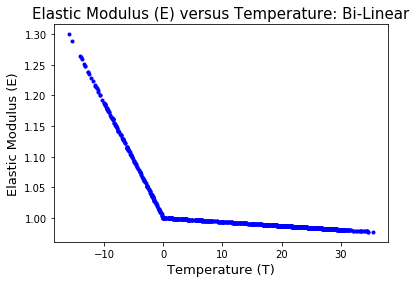

In [10]:
%matplotlib inline
plt.plot(t[0], Factor, 'bo', linewidth=2, markersize=3)
plt.title('Elastic Modulus (E) versus Temperature: ' + title_Freq_VS_t_str, fontsize=15)
plt.xlabel('Temperature (T)',fontsize=13)
plt.ylabel('Elastic Modulus (E)',fontsize=13)
plt.show

In [11]:
## Define Initial Training and Test samples
range_ = [1, n_init, Freq.shape[1]]
IND_x0 = np.arange(range_[0]-1, range_[1]) # DEFINE INDEX FOR INITIAL SAMPLES
IND_x1 = np.arange(range_[1], range_[2]) # DEFINE INDEX FOR TEST SAMPLES


In [12]:
## Inject Noise into Freq.

Freq = np.transpose(Freq)

In [13]:
## Inject Noise into Freq.

noise = np.zeros(Freq.shape)
SNR = np.zeros(Freq.shape[1])

for i in range(0, Freq.shape[1]) :
    RMS = np.linalg.norm(Freq[:,i])/np.sqrt(Freq.shape[0])
    noise[:,i] = (RMS*noise_amp*np.random.randn(Freq.shape[0],1))[:,0] # RMS NOISE
    RMS_n = np.linalg.norm(noise[:,i])/np.sqrt(len(noise[:,i]))
    SNR[i] = 20*np.log10((RMS/RMS_n)) # SIGNAL TO NOISE  

f = Freq + noise;


<function matplotlib.pyplot.show>

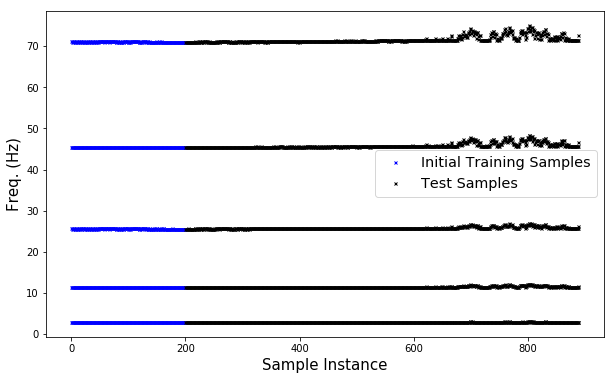

In [14]:
## Plot Simulated Freq. (Noise contaminated)


#fig, axs = plt.subplots(f.shape[1], 1, figsize=(15, 15), facecolor='w', edgecolor='k')

#axs = axs.ravel()

fig = plt.figure(figsize=(10, 6))

for i in range(f.shape[1]):

    if i == 0:
        plt.plot(IND_x0, f[IND_x0,i], 'bx', linewidth=4, markersize=3,  label='Initial Training Samples')
        plt.plot(IND_x1, f[IND_x1,i], 'kx', linewidth=4, markersize=3,  label='Test Samples')
    else :
        plt.plot(IND_x0, f[IND_x0,i], 'bx', linewidth=4, markersize=3)
        plt.plot(IND_x1, f[IND_x1,i], 'kx', linewidth=4, markersize=3)
        
plt.xlabel('Sample Instance', fontsize=15)
plt.ylabel('Freq. (Hz)', fontsize=15)
plt.legend(fontsize='x-large')
plt.show

# To-do : Check YLIM in original Matlab code 

# if D_point[:, 0] == 0 :
# else :
#     plt.plot(D_point[:, 0]*[1 1],YLIM,'r:','linewidth',2)


In [15]:
op = {}

op['f'] = f; # Noisy Freq.
op['t'] = t; # Temperature
op['IND_x0'] = IND_x0; # Sample Indices for Initial Training Samples
op['IND_x1'] = IND_x1; # Sample Indices for Test Samples

# The below parameters are not used for DAMAGE DETECTION
op['infor'] = {}
op['infor']['F_vs_t'] = title_Freq_VS_t_str; # Dependency (FREQ. VS TEMP) Type
op['infor']['n_init'] = n_init;   # Size of Initial Training Data
op['infor']['noise_amp'] = noise_amp; # Noise Level
op['infor']['D_point'] = D_point[0]; # Sample index at damage (e.g., 0 => no damage // 700 => damage at #sample index of 700
op['infor']['D_Quan'] = D_Quan[0]; # Stiffness reduction ratio for damage elements (#10 & #11)



In [16]:
with open(fn_sv, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(op, f)    